In [30]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

In [20]:
MODEL_NAME = 'roberta-base'
TEXT_COLUMN = 'statement'
LABEL_COLUMN = 'status'

MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Đang sử dụng GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Đang sử dụng CPU.")
    
print("CUDA version:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Không có")


Đang sử dụng GPU: NVIDIA GeForce MX550
CUDA version: 12.8
GPU available: True
GPU name: NVIDIA GeForce MX550


In [12]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nltk_pos_to_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
DATA_FILENAME = "C:\\Users\\pc\\Downloads\\Combined Data.csv\\Combined Data.csv"


try:
    df = pd.read_csv(DATA_FILENAME)
except Exception as e:
    print(f"Lỗi khi đọc file CSV '{DATA_FILENAME}': {e}")
    exit()

if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    print(f"Lỗi: Các cột '{TEXT_COLUMN}' hoặc '{LABEL_COLUMN}' không tồn tại trong file CSV.")
    print(f"Các cột hiện có: {df.columns.tolist()}")
    print("Vui lòng kiểm tra lại tên cột trong phần Cấu hình hoặc trong file CSV của bạn.")
    exit()

df = df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN])
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str)

  Đang tạo Word Cloud cho nhãn: 'Anxiety' (3841 mẫu)...


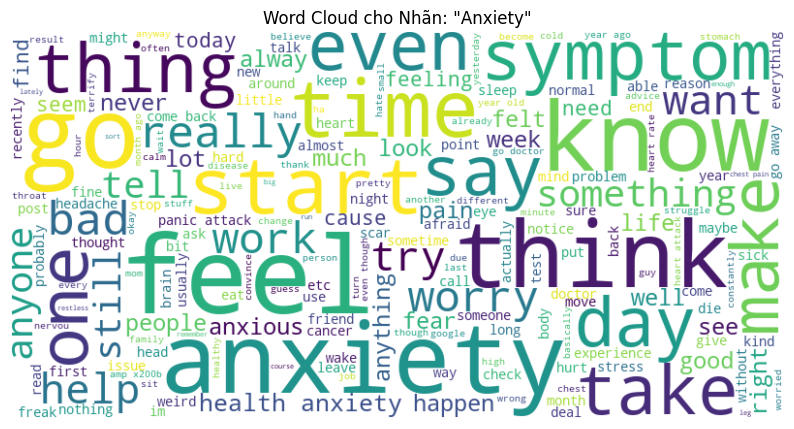

  Đang tạo Word Cloud cho nhãn: 'Bipolar' (2777 mẫu)...


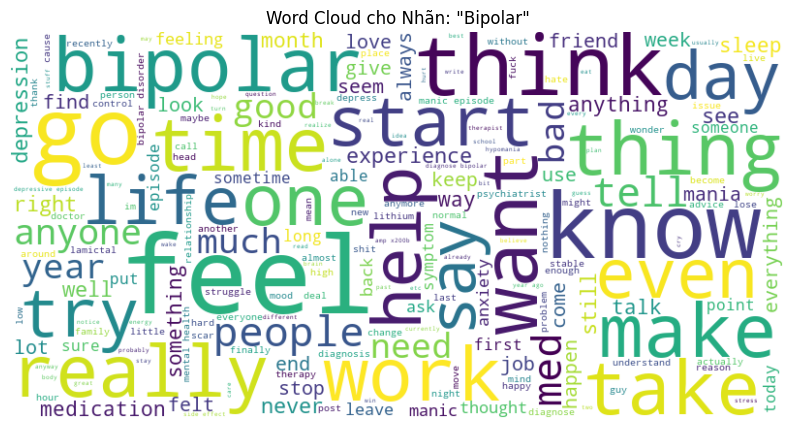

  Đang tạo Word Cloud cho nhãn: 'Depression' (15404 mẫu)...


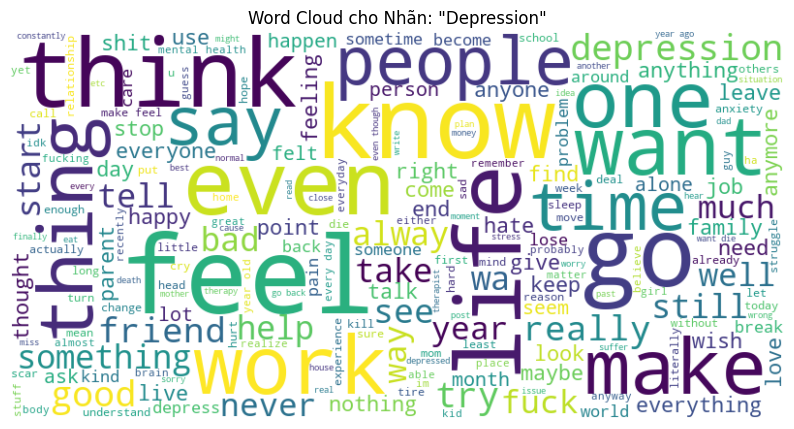

  Đang tạo Word Cloud cho nhãn: 'Normal' (16343 mẫu)...


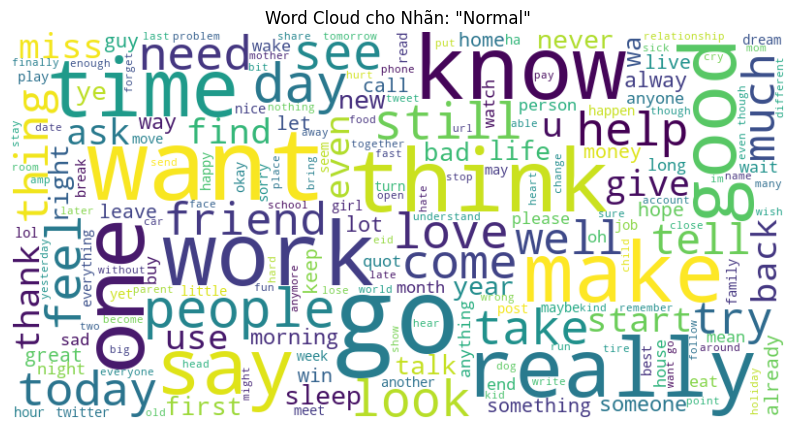

  Đang tạo Word Cloud cho nhãn: 'Personality disorder' (1077 mẫu)...


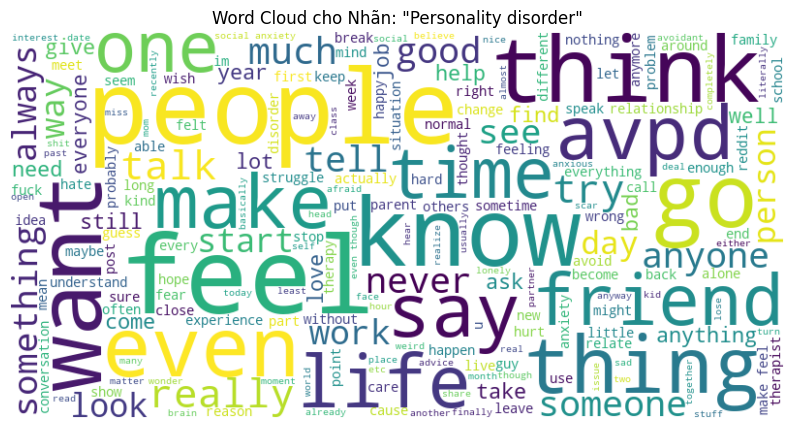

  Đang tạo Word Cloud cho nhãn: 'Stress' (2587 mẫu)...


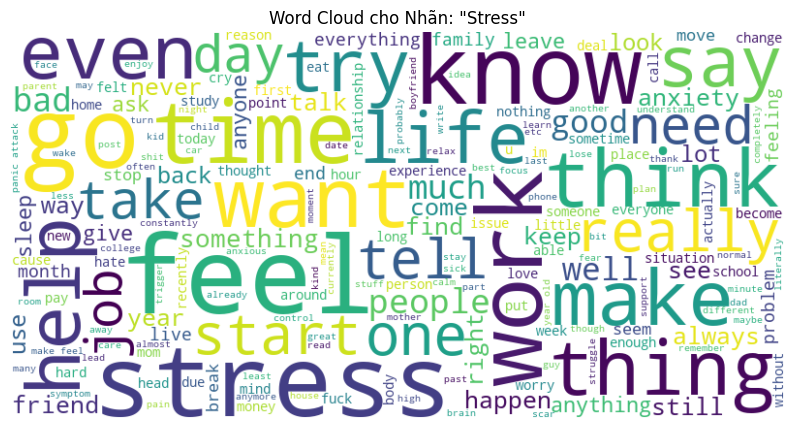

  Đang tạo Word Cloud cho nhãn: 'Suicidal' (10652 mẫu)...


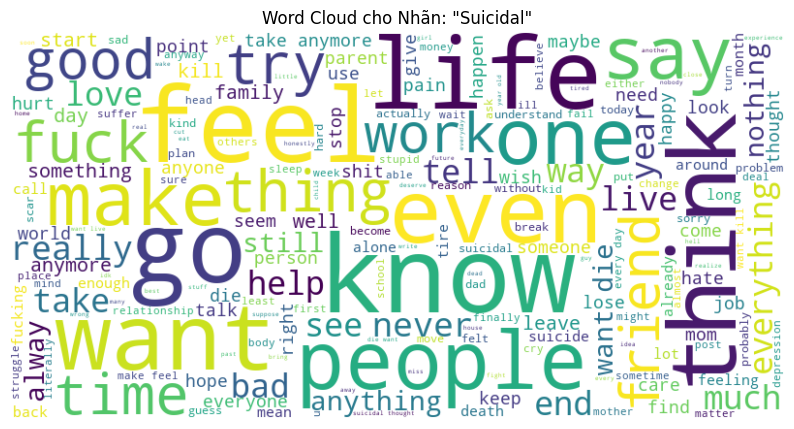


Các nhãn gốc: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Các nhãn đã mã hóa: [0 1 2 3 4 5 6]
Số lượng nhãn: 7
Ví dụ dữ liệu sau khi mã hóa nhãn và xử lý văn bản:
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                      processed_text   status  label_encoded  
0                                            oh gosh  Anxiety              0  
1     trouble sleep confuse mind restless heart tune  Anxiety              0  
2  wrong back dear forward doubt stay restless re...  Anxiety              0  
3             shift focus something else still worry  Anxiety              0  
4                   restless restless month boy mean  Anxiet

In [ ]:


def preprocess_text(text):
    # 1. Chuyển về chữ thường
    text = text.lower()
    # 2. Xóa ký tự đặc biệt (chỉ giữ lại chữ cái, số và khoảng trắng)
    text = re.sub(r'[^a-z0-9\s]', ' ', text) # <-- Thay thế bằng khoảng trắng thay vì rỗng để tách từ đúng
    # 3. Xóa các khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()

    if not text: # Xử lý trường hợp chuỗi rỗng sau khi làm sạch
        return ""

    # 4. Tách từ
    words = text.split()

    # 5. Gán nhãn loại từ (POS tagging)
    pos_tagged_words = pos_tag(words)

    # 6. Lemmatization
    lemmatized_words = []
    for word, tag in pos_tagged_words:
        # Chuyển nhãn POS của NLTK sang định dạng của WordNetLemmatizer
        wn_tag = nltk_pos_to_wordnet_pos(tag)
        # Lemmatize từ với nhãn POS tương ứng
        lemma = lemmatizer.lemmatize(word, wn_tag)
        lemmatized_words.append(lemma)

    # 7. Loại bỏ stopwords (áp dụng trên các từ ĐÃ được lemmatized)
    filtered_words = [word for word in lemmatized_words if word not in stop_words]

    # 8. Gộp lại thành chuỗi
    text = " ".join(filtered_words)

    return text

df['processed_text'] = df[TEXT_COLUMN].apply(preprocess_text)

# Mã hóa nhãn sau khi đã xử lý văn bản
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df[LABEL_COLUMN])
NUM_LABELS = len(label_encoder.classes_)
class_names = label_encoder.classes_


df['processed_text'] = df[TEXT_COLUMN].apply(preprocess_text)
all_text = " ".join(df['processed_text'].tolist())


# Vẽ word cloud
for label_name in class_names:
    label_df = df[df[LABEL_COLUMN] == label_name]

    if len(label_df) == 0:
        print(f"  Không có dữ liệu cho nhãn: '{label_name}'. Bỏ qua Word Cloud.")
        continue
    all_text_for_label = " ".join(label_df['processed_text'].tolist())
    if len(all_text_for_label.strip()) == 0:
         print(f"  Văn bản cho nhãn '{label_name}' rỗng sau khi xử lý. Bỏ qua Word Cloud.")
         continue
    print(f"  Đang tạo Word Cloud cho nhãn: '{label_name}' ({len(label_df)} mẫu)...")

    # Tạo và hiển thị Word Cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_text_for_label)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Word Cloud cho Nhãn: "{label_name}"')
    plt.show()


label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df[LABEL_COLUMN])
NUM_LABELS = len(label_encoder.classes_)
print(f"\nCác nhãn gốc: {label_encoder.classes_}")
print(f"Các nhãn đã mã hóa: {label_encoder.transform(label_encoder.classes_)}")
print(f"Số lượng nhãn: {NUM_LABELS}")
print(f"Ví dụ dữ liệu sau khi mã hóa nhãn và xử lý văn bản:\n{df[[TEXT_COLUMN, 'processed_text', LABEL_COLUMN, 'label_encoded']].head()}")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df['label_encoded'].tolist()
)
print(f"\nSố lượng mẫu huấn luyện: {len(train_texts)}")
print(f"Số lượng mẫu kiểm định: {len(val_texts)}")

In [17]:
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LENGTH)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LENGTH)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [28]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [23]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [31]:
def train_epoch(model, data_loader, optimizer, scheduler, device, epoch_num, total_epochs):
    model.train()
    total_loss = 0
    print(f"\nBắt đầu Epoch {epoch_num + 1}/{total_epochs}")
    for batch_idx, batch in enumerate(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if (batch_idx + 1) % 50 == 0:
             print(f"  Epoch {epoch_num + 1}, Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(data_loader)
    print(f"Kết thúc Epoch {epoch_num + 1}. Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

def evaluate_model(model, data_loader, device, label_encoder_classes):
    model.eval()
    all_predictions = []
    all_actual_labels = []
    total_loss = 0
    print("\nĐang đánh giá trên tập validation...")
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_predictions.extend(preds)
            all_actual_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_actual_labels, all_predictions)
    report = classification_report(all_actual_labels, all_predictions, target_names=label_encoder_classes, zero_division=0)

    # Tính toán confusion matrix
    cm = confusion_matrix(all_actual_labels, all_predictions)

    return avg_loss, accuracy, report, cm, all_actual_labels, all_predictions

def plot_confusion_matrix(cm, class_names, epoch_num):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Epoch {epoch_num + 1}')
    plt.ylabel('Nhãn Thực Tế (Actual)')
    plt.xlabel('Nhãn Dự Đoán (Predicted)')
    plt.show()

In [37]:

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, epoch, EPOCHS)
    
    class_names = label_encoder.classes_
    val_loss, val_accuracy, val_report, val_cm, _, _ = evaluate_model(model, val_loader, device, class_names)

    print(f"\n--- Kết quả đánh giá Epoch {epoch + 1}/{EPOCHS} ---")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Validation Classification Report:")
    print(val_report)

    plot_confusion_matrix(val_cm, class_names, epoch)
    print("-" * 50)



Bắt đầu Epoch 1/4


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
output_dir = './roberta_sentiment_model_colab'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"\nLưu mô hình vào thư mục: {output_dir}")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))
print(f"Đã lưu mô hình, tokenizer và label encoder vào {output_dir}")
print(f"Bạn có thể tải thư mục này về bằng cách nén nó lại: !zip -r {output_dir}.zip {output_dir}")
print(f"Sau đó tìm file {output_dir}.zip trong cây thư mục bên trái và tải về.")


Lưu mô hình vào thư mục: ./roberta_sentiment_model_colab
Đã lưu mô hình, tokenizer và label encoder vào ./roberta_sentiment_model_colab
Bạn có thể tải thư mục này về bằng cách nén nó lại: !zip -r ./roberta_sentiment_model_colab.zip ./roberta_sentiment_model_colab
Sau đó tìm file ./roberta_sentiment_model_colab.zip trong cây thư mục bên trái và tải về.


In [ ]:
print("\n--- Ví dụ tải lại mô hình và dự đoán ---")
loaded_tokenizer = RobertaTokenizerFast.from_pretrained(output_dir)
loaded_model = RobertaForSequenceClassification.from_pretrained(output_dir)
loaded_model.to(device)
loaded_label_encoder = joblib.load(os.path.join(output_dir, 'label_encoder.pkl'))

def predict_sentiment(text, model, tokenizer, label_encoder, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    prediction_idx = torch.argmax(logits, dim=1).cpu().item()
    predicted_label_text = label_encoder.inverse_transform([prediction_idx])[0]
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_confidence = probabilities[prediction_idx]
    return predicted_label_text, predicted_confidence, probabilities

print("\n--- Thử nghiệm dự đoán với mô hình đã tải ---")

test_texts_examples = [
    "oh my gosh!",
    "trouble sleeping, confused mind, restless heart. All out of tune",
    "I AM FEELING VERY HAPPY AND JOYFUL TODAY!!!",
    "This is a terrible experience, I am so angry.",
    "   The weather is quite neutral, nothing special.   "
]

for text_example in test_texts_examples:
    pred_label, pred_conf, all_probs = predict_sentiment(text_example, loaded_model, loaded_tokenizer, loaded_label_encoder, device)
    print(f"\nText: '{text_example}'")
    print(f"  Predicted Label: {pred_label} (Confidence: {pred_conf:.4f})")



--- Ví dụ tải lại mô hình và dự đoán ---

--- Thử nghiệm dự đoán với mô hình đã tải ---

Text: 'oh my gosh!'
  Predicted Label: Normal (Confidence: 0.9988)

Text: 'trouble sleeping, confused mind, restless heart. All out of tune'
  Predicted Label: Anxiety (Confidence: 0.9980)

Text: 'I AM FEELING VERY HAPPY AND JOYFUL TODAY!!!'
  Predicted Label: Normal (Confidence: 0.9782)

Text: 'This is a terrible experience, I am so angry.'
  Predicted Label: Normal (Confidence: 0.6872)

Text: '   The weather is quite neutral, nothing special.   '
  Predicted Label: Normal (Confidence: 0.9887)
